### Weakly-supervised learning

The idea of this notebook is to train a neural network at reconstructing spectra while also using weakly supervised learning to ensure that a fraction of the representation is as well preserved as possible for stars from the same cluster.

In [1]:
import apogee.tools.read as apread
import matplotlib.pyplot as plt 
import apogee.tools.path as apogee_path
from apogee.tools import bitmask

import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn

from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load,generate_loss_with_masking

import apoNN.src.vectors as vector


from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder,Discriminator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
apogee_path.change_dr(16)





[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


### Hyperparameters

We dump here all of our hyperparmeters for dealing with latter

In [2]:
dataset_name = "aspcap_training_clean"
recenter=True
n_bins = 8575
n_z = 16
n_shared = 5
activation = nn.LeakyReLU()
lr = 0.0001
n_batch = 64
encoder_architecture = [n_bins,1024,512,128,n_z]
decoder_architecture = [n_z,128,512,1024,n_bins]

### Setting up the data


We need two datasets. One containing the full dataset and another containing the occam dataset

In [3]:
dataset = AspcapDataset(filename=dataset_name,recenter=recenter)
dataset_occam = AspcapDataset(filename="aspcap_occam",recenter=True,tensor_type=torch.FloatTensor)

In [4]:
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = n_batch,
                                     shuffle= True,
                                     drop_last=True)

In [5]:
occam = load("occam")
occam_cluster_idxs = occam["cluster_idxs"]
registry = vector.OccamLatentVector.make_registry(occam_cluster_idxs)

creating a neural network

In [19]:
encoder = Feedforward(encoder_architecture ,activation=activation).to(device)
decoder = Feedforward(decoder_architecture ,activation=activation).to(device)
autoencoder = Autoencoder(encoder,decoder,n_bins=n_bins).to(device)
critic_feedforward = Feedforward([n_z,128,32,1] ,activation=activation).to(device)
critic = Discriminator(critic_feedforward)

optimizer_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=lr)
optimizer_critic = torch.optim.Adam(critic.parameters(), lr=0.001)



In [20]:
loss = nn.L1Loss()
adversarial_loss = nn.BCELoss()
masked_loss = generate_loss_with_masking(loss)


### Training Loop

In [21]:
ones = torch.ones(n_batch,1)
zeroes = torch.ones(n_batch,1)*0


In [23]:
training_loss= []
for i in range(30000):
    for j,(x,x_raw,x_err,idx) in enumerate(loader):
        
        x_pred,z = autoencoder(x.to(device))
        z_fake = torch.randn(z.shape)*0.01
        
        err_real = adversarial_loss(critic(z.detach()),ones)
        err_fake = adversarial_loss(critic(z_fake),zeroes)
        critic_loss = err_real+err_fake #train critic to match real samples to 1 and fake samples to 0
        optimizer_critic.zero_grad()
        critic_loss.backward()
        optimizer_critic.step()
        
        
        mask_spec = x_err<dataset.err_threshold
        err_pred = masked_loss(x_pred,x.to(device),mask_spec)
        err_fool = adversarial_loss(critic(z),zeroes) #  train autoencoder to make real data look like fake data ie make real data look like gaussian
        
        err_tot = err_pred + 0.2*err_fool
        optimizer_autoencoder.zero_grad()
        err_tot.backward()
        optimizer_autoencoder.step()
        print(f"err:{err_tot},err_pred:{err_pred},err_fool:{err_fool}")#,err_critic:{critic_loss}")
    training_loss.append(err_pred.item())
                 

err:0.3092493414878845,err_pred:0.0075042471289634705,err_fool:1.5087254047393799
err:0.31895291805267334,err_pred:0.008357346057891846,err_fool:1.5529778003692627
err:0.3346936106681824,err_pred:0.0071205743588507175,err_fool:1.6378650665283203
err:0.3357886075973511,err_pred:0.007822643965482712,err_fool:1.6398298740386963
err:0.33651819825172424,err_pred:0.007912199944257736,err_fool:1.643030047416687
err:0.32835105061531067,err_pred:0.009049695916473866,err_fool:1.5965068340301514
err:0.3280923664569855,err_pred:0.008815553970634937,err_fool:1.596384048461914
err:0.31968238949775696,err_pred:0.007549102883785963,err_fool:1.5606664419174194
err:0.3072534501552582,err_pred:0.007555273827165365,err_fool:1.498490810394287
err:0.3127235770225525,err_pred:0.008506877347826958,err_fool:1.5210834741592407
err:0.2949830889701843,err_pred:0.008606163784861565,err_fool:1.431884527206421
err:0.29508036375045776,err_pred:0.008760672062635422,err_fool:1.4315985441207886
err:0.2847679555416107,er

err:0.1460162103176117,err_pred:0.008201942779123783,err_fool:0.6890713572502136
err:0.14218446612358093,err_pred:0.007591492496430874,err_fool:0.672964870929718
err:0.14481152594089508,err_pred:0.008977803401648998,err_fool:0.6791685819625854
err:0.14168961346149445,err_pred:0.007895871996879578,err_fool:0.668968677520752
err:0.14230306446552277,err_pred:0.008009303361177444,err_fool:0.6714687943458557
err:0.14113663136959076,err_pred:0.00768254091963172,err_fool:0.6672704219818115
err:0.14177170395851135,err_pred:0.008336774073541164,err_fool:0.6671746969223022
err:0.13996684551239014,err_pred:0.007136279717087746,err_fool:0.6641528010368347
err:0.14054889976978302,err_pred:0.007444468326866627,err_fool:0.6655220985412598
err:0.14040274918079376,err_pred:0.0073380484245717525,err_fool:0.6653234958648682
err:0.14149336516857147,err_pred:0.008279022760689259,err_fool:0.6660717129707336
err:0.14121335744857788,err_pred:0.007714990526437759,err_fool:0.6674918532371521
err:0.1408525109291

err:0.1483546942472458,err_pred:0.007624856662005186,err_fool:0.7036492228507996
err:0.1487724334001541,err_pred:0.007485610898584127,err_fool:0.7064340710639954
err:0.1495305746793747,err_pred:0.008204737678170204,err_fool:0.7066291570663452
err:0.14860834181308746,err_pred:0.007449255790561438,err_fool:0.705795407295227
err:0.14897799491882324,err_pred:0.007560985162854195,err_fool:0.7070850133895874


KeyboardInterrupt: 

In [ ]:
critic(z)[0:10]

In [ ]:
critic(z)[0:10]

In [ ]:
z_fake = torch.randn(5000,8)

(array([ 3.40670456,  3.40670595, 34.06705257, 20.44023154, 23.8469368 ,
        47.69387359, 40.88046308, 34.06705257,  6.81340913,  3.40670595]),
 array([-0.02332417, -0.01873762, -0.01415108, -0.00956454, -0.00497799,
        -0.00039145,  0.00419509,  0.00878164,  0.01336818,  0.01795472,
         0.02254126], dtype=float32),
 <a list of 10 Patch objects>)

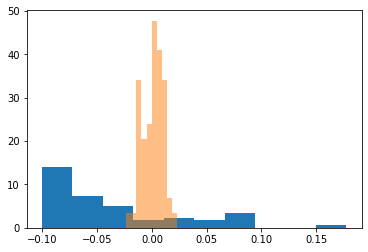

In [26]:
plt.hist(z[:,3].detach(),density=True)
plt.hist(z_fake[:,3].detach(),alpha=0.5,density=True)

In [ ]:
z.shape

In [ ]:
def generate_(batch_size):
    return torch.from_numpy(np.random.multivariate_normal(mean=[0,0],cov =[[1,0],[0,1]],size=batch_size)).type(torch.float)



In [ ]:
torch.randn(z.shape)